In [61]:
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

from tqdm import tqdm

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    ])

# Fashion MNIST dataset
trainset = datasets.FashionMNIST(root='./data',
                            train=True, 
                            transform=transform,
                            download=True)
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

- 使用 `torch.utils.data.random_split(trainset, [train_size, valid_size])` 划分训练集和验证集

In [63]:
train_size = int(0.8 * len(trainset))  # 训练集和验证集8:2划分
valid_size = len(trainset) - train_size
trainset, validset = torch.utils.data.random_split(trainset, [train_size, valid_size])

- 使用 `DataLoader` 加载数据集

In [64]:
# Data loader
train_loader = DataLoader(dataset=trainset,
                          batch_size=512,
                          shuffle=True)
valid_loader = DataLoader(dataset=validset,
                            batch_size=512,
                            shuffle=True)
test_loader = DataLoader(dataset=testset,
                            batch_size=512,
                            shuffle=False)

len(train_loader), len(valid_loader), len(test_loader)

(94, 24, 20)

In [65]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
).to(device)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

100%|██████████| 24/24 [00:02<00:00, 11.55it/s]


epoch 0, train loss 2.3229, valid loss 2.2215, train acc 0.180, valid acc 0.185


100%|██████████| 24/24 [00:01<00:00, 14.48it/s]


epoch 1, train loss 2.1469, valid loss 2.0750, train acc 0.308, valid acc 0.314


100%|██████████| 24/24 [00:01<00:00, 13.26it/s]


epoch 2, train loss 2.0165, valid loss 1.9611, train acc 0.427, valid acc 0.433


100%|██████████| 24/24 [00:01<00:00, 13.73it/s]


epoch 3, train loss 1.9120, valid loss 1.8666, train acc 0.509, valid acc 0.515


100%|██████████| 24/24 [00:01<00:00, 14.78it/s]


epoch 4, train loss 1.8233, valid loss 1.7847, train acc 0.549, valid acc 0.553


100%|██████████| 24/24 [00:01<00:00, 14.46it/s]


epoch 5, train loss 1.7454, valid loss 1.7121, train acc 0.574, valid acc 0.577


100%|██████████| 24/24 [00:03<00:00,  7.79it/s]


epoch 6, train loss 1.6760, valid loss 1.6470, train acc 0.591, valid acc 0.593


100%|██████████| 24/24 [00:01<00:00, 15.01it/s]


epoch 7, train loss 1.6136, valid loss 1.5882, train acc 0.603, valid acc 0.606


100%|██████████| 24/24 [00:01<00:00, 13.18it/s]


epoch 8, train loss 1.5573, valid loss 1.5351, train acc 0.614, valid acc 0.615


100%|██████████| 24/24 [00:01<00:00, 14.22it/s]


epoch 9, train loss 1.5065, valid loss 1.4868, train acc 0.622, valid acc 0.623


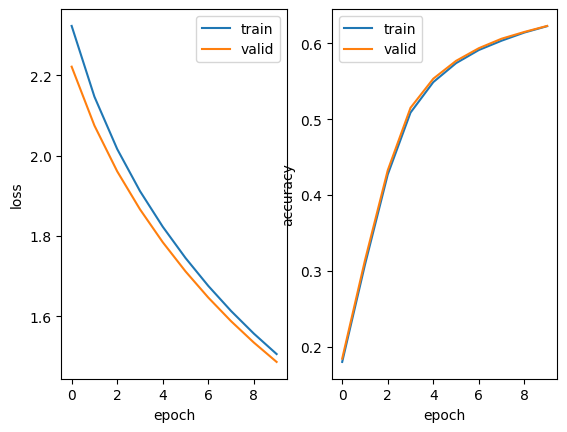

In [66]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0006)

num_epochs = 10

def evaluate_accuracy(net, data_iter):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().cpu().item()
        n += y.shape[0]
    return acc_sum / n

def train(net, train_iter, valid_iter, loss, num_epochs, trainer):
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []
    for epoch in range(num_epochs):
        net.train()
        running_train_loss = 0.0
        for X, y in tqdm(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
            running_train_loss += l.item() * X.size(0)  # 累加批次损失
        # 计算平均训练损失
        train_loss.append(running_train_loss / len(train_iter.dataset))
        # 计算验证损失和准确率
        net.eval()
        running_valid_loss = 0.0
        with torch.no_grad():
            for X, y in tqdm(valid_iter):
                X, y = X.to(device), y.to(device)
                l = loss(net(X), y)
                running_valid_loss += l.item() * X.size(0)  # 累加批次损失
            valid_loss.append(running_valid_loss / len(valid_iter.dataset))
            train_acc.append(evaluate_accuracy(net, train_iter))
            valid_acc.append(evaluate_accuracy(net, valid_iter))
        if epoch % 1 == 0:
            print('epoch %d, train loss %.4f, valid loss %.4f, train acc %.3f, valid acc %.3f'
                  % (epoch, train_loss[-1], valid_loss[-1], train_acc[-1], valid_acc[-1]))
    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train')
    plt.plot(valid_loss, label='valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train')
    plt.plot(valid_acc, label='valid')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    
train(net, train_loader, valid_loader, criteria, num_epochs, optimizer)